In [1]:
import re
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,multilabel_confusion_matrix,accuracy_score,recall_score
from scipy.stats import f_oneway
from nltk.probability import FreqDist
import contractions
import spacy
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import operator
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
# Fonte de dados https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
df = pd.read_csv(r'trab\data.csv',encoding='utf-8')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Não há dados nulos

Pre_processamento para análise exploratória


In [23]:
def sub_abrev (frase):
    sub_dict={'mn':'million','mln':'million','co':'company','pct':'percentage',
         'eps':'earnings per share','fb':'Facebook','hod':'high of day',
         'bln':'billion','bn':'billion'}
    pattern = re.compile(r'\bmn\b|\bmln\b|\bco\b|\bpct\b|\beps\b|\bfb\b|\bhod\b|\bbln\b|\bbn\b')
    nova_frase =re.sub(pattern,lambda x:sub_dict.get(x.group()) ,frase)
    return nova_frase

def pre_processamento(frase):  
    
    #Cria tokens
    token_lista=re.findall(r"\w+(?:'\w+)?|[^\w\s]",frase)
    token_lista = [token.lower() for token in token_lista]
    #remove stopwords e pontuacao
    stopw = stopwords.words('english')
    pontuacao = [pontuacao for pontuacao in string.punctuation]
    lst_rmv = stopw + pontuacao 
    token_lista=[token for token in token_lista if token not in lst_rmv]
    #remove numeros
    token_lista=[token for token in token_lista if not token.isdigit()]
    #remove termos com apenas uma letra
    token_lista=[token for token in token_lista if len(token)>1]
    return token_lista 

df['Sentence']=df['Sentence'].apply(sub_abrev)
df['processado'] =df['Sentence'].apply(pre_processamento)

#bag of words para identificar palavras mais comuns
all_pos_pp=[token for lista in df.loc[df.Sentiment=='positive']['processado'] for token in lista]
all_neg_pp=[token for lista in df.loc[df.Sentiment=='negative']['processado'] for token in lista]
all_neut_pp=[token for lista in df.loc[df.Sentiment=='neutral']['processado'] for token in lista]

#Junção das sentenças para reconhecimeto de entidades
all_pos='. '.join(df.loc[df.Sentiment=='positive']['Sentence'])
all_neg='. '.join(df.loc[df.Sentiment=='negative']['Sentence'])
all_neut='. '.join(df.loc[df.Sentiment=='neutral']['Sentence'])


df['tamanho']=df['Sentence'].apply(len)
df['n_tokens']=df['processado'].apply(len)

# Análise exploratória

Tamanho

In [5]:
grupo=df.groupby('Sentiment')['tamanho']
grupo.describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
negative,860.0,107.717442,52.723015,12.0,67.0,97.5,136.0,306.0
neutral,3130.0,123.921406,57.026435,9.0,80.0,115.0,159.0,315.0
positive,1852.0,113.717603,56.600676,10.0,68.0,103.0,147.0,303.0


Sentenças neutras são em média maiores e negativas são menores

In [6]:
grupo_lst=grupo.apply(list)
f_oneway(grupo_lst[0],grupo_lst[1],grupo_lst[2])

F_onewayResult(statistic=36.95846799482342, pvalue=1.1217272573050914e-16)

O teste ANOVA one way mostra que as médias dos tamanhos são estatisticamento diferentes com um grau de confiança de 95% de confiança

Número de tokens

In [25]:
grupo=df.groupby('Sentiment')['n_tokens']
grupo.describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
negative,860.0,10.881395,4.987984,2.0,7.0,10.0,13.0,29.0
neutral,3130.0,11.707668,5.741127,0.0,7.0,11.0,15.0,41.0
positive,1852.0,11.526998,5.460711,1.0,7.0,10.0,15.0,32.0


In [7]:
frequencia = FreqDist(all_pos_pp)
print(f""" Termos mais comuns em frases positivas:
{frequencia.most_common(10)}""")

 Termos mais comuns em frases positivas:
[('million', 528), ('eur', 437), ('company', 380), ('year', 218), ('sales', 216), ('profit', 203), ('net', 197), ('said', 194), ('finnish', 181), ('period', 140)]


In [8]:
frequencia = FreqDist(all_neg_pp)
print(f""" Termos mais comuns em frases negativas:
{frequencia.most_common(10)}""")

 Termos mais comuns em frases negativas:
[('million', 367), ('eur', 311), ('company', 167), ('profit', 154), ('sales', 105), ('year', 100), ('net', 100), ('finnish', 91), ('operating', 89), ('quarter', 87)]


In [9]:
frequencia = FreqDist(all_neut_pp)
print(f""" Termos mais comuns em frases neutras:
{frequencia.most_common(10)}""")

 Termos mais comuns em frases neutras:
[('million', 678), ('company', 540), ('eur', 538), ('finnish', 267), ('said', 258), ('sales', 241), ('finland', 236), ('profit', 212), ('net', 203), ('group', 199)]


Aparentemetne não há distinção entre os sentimento das frases e a frequência dos termos.

In [10]:
nlp = spacy.load("en_core_web_sm")
def get_ents(texto):
    nlp_texto=nlp(texto)
    return(nlp_texto.ents)

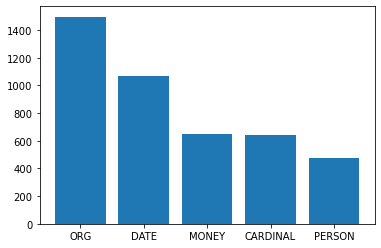

In [11]:
ent_label_pos= [ent.label_ for ent in get_ents(all_pos)]
label_counts={ent:ent_label_pos.count(ent) for ent in ent_label_pos}
label_counts=dict(sorted(label_counts.items(), key=lambda item: item[1],reverse=True))
plt.bar(range(5),list(label_counts.values())[:5]);
plt.xticks(range(5),list(label_counts.keys())[:5]);

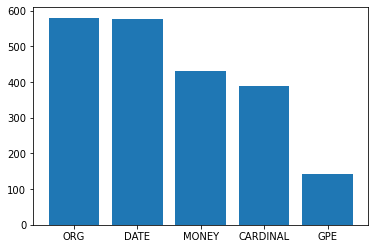

In [12]:
ent_label_neg= [ent.label_ for ent in get_ents(all_neg)]
label_counts={ent:ent_label_neg.count(ent) for ent in ent_label_neg}
label_counts=dict(sorted(label_counts.items(), key=lambda item: item[1],reverse=True))
plt.bar(range(5),list(label_counts.values())[:5]);
plt.xticks(range(5),list(label_counts.keys())[:5]);

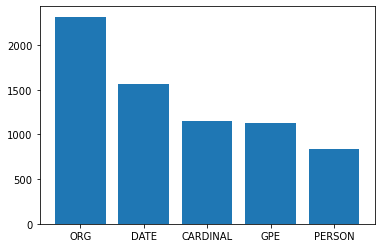

In [13]:
ent_label_neut= [ent.label_ for ent in get_ents(all_neut)]
label_counts={ent:ent_label_neut.count(ent) for ent in ent_label_neut}
label_counts=dict(sorted(label_counts.items(), key=lambda item: item[1],reverse=True))
plt.bar(range(5),list(label_counts.values())[:5]);
plt.xticks(range(5),list(label_counts.keys())[:5]);

As distribuições de entidades são muito parecidas entre os sentimentos. Alguns pontos notaveis é como "data" tem uma proporção maior quando comparadas a outras entidades em frases com sentimento negativo do que em frases com sentimento positivo. Apesar de "dinheiro" não estar presente no top 5 de frases neutras é a sexta mais comum.

# Análise de Sentimentos

## Vader

In [14]:
analyzer = SentimentIntensityAnalyzer()
score_dict ={'neu':'neutral','pos':'positive','neg':'negative'}
def vader(texto,pos_thresh,neg_thresh):
    scores= analyzer.polarity_scores(texto)
    score = scores.pop('compound')
    if score > pos_thresh:
        return 'positive'
    elif score > neg_thresh:
        return 'neutral'
    else:
        return 'negative'

Separar corpus em treino e teste para definição dos thresholds de classificação

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(df['Sentence'],df['Sentiment'],train_size=0.7,random_state=42)

Definição negative threshold

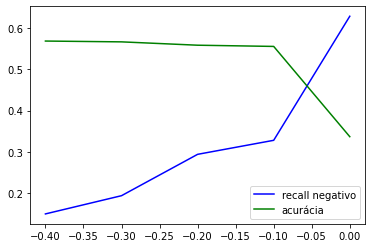

In [16]:
pos_thresh=0.35
neg_thresh_lst =[0,-0.1,-0.2,-0.3,-0.4]
neg_recall =[]
accuracy=[]
for thresh in neg_thresh_lst:
    vader_score = [vader(frase,pos_thresh,thresh) for frase in X_train]
    report =classification_report(Y_train,vader_score,output_dict=True)
    neg_recall.append(report['negative']['recall'])
    accuracy.append(report['accuracy'])
    
plt.plot(neg_thresh_lst,neg_recall,color='blue',label='recall negativo')
plt.plot(neg_thresh_lst,accuracy,color='green',label='acurácia')
plt.legend()

Avaliando o gráfico o thhreshodl ideal aparenta estar entre 0 e -0.1

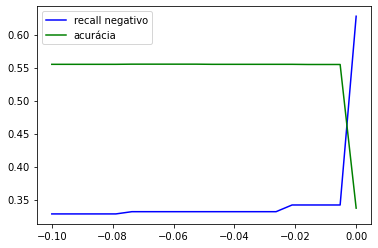

In [17]:
pos_thresh=0.35
neg_thresh_lst =np.linspace(0,-0.1,20)
neg_recall =[]
accuracy=[]
for thresh in neg_thresh_lst:
    vader_score = [vader(frase,pos_thresh,thresh) for frase in X_train]
    report =classification_report(Y_train,vader_score,output_dict=True)
    neg_recall.append(report['negative']['recall'])
    accuracy.append(report['accuracy'])
    
plt.plot(neg_thresh_lst,neg_recall,color='blue',label='recall negativo')
plt.plot(neg_thresh_lst,accuracy,color='green',label='acurácia')
plt.legend()

In [18]:
neg_thresh_df=pd.DataFrame({'acuracia':accuracy,'recall_neg':neg_recall,'threshold':neg_thresh_lst})

In [19]:
neg_thresh_df

,acuracia,recall_neg,threshold
0,0.337002,0.627750,0.000000
1,0.554659,0.341794,-0.005263
2,0.554659,0.341794,-0.010526
3,0.554659,0.341794,-0.015789
4,0.554903,0.341794,-0.021053
5,0.554903,0.331641,-0.026316
6,0.554903,0.331641,-0.031579
7,0.554903,0.331641,-0.036842
8,0.554903,0.331641,-0.042105
9,0.554903,0.331641,-0.047368


O threshold ideal aprenta ser muito próximo de 0, utilizarei como sendo -0.021053

Definição threshold positivo

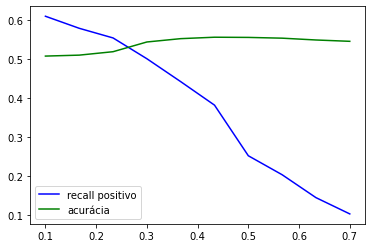

In [20]:
neg_thresh=-0.021053
pos_thresh_lst =np.linspace(0.1,0.7,10)
pos_recall =[]
accuracy=[]
for thresh in pos_thresh_lst:
    vader_score = [vader(frase,thresh,neg_thresh) for frase in X_train]
    report =classification_report(Y_train,vader_score,output_dict=True)
    pos_recall.append(report['positive']['recall'])
    accuracy.append(report['accuracy'])
    
plt.plot(pos_thresh_lst,pos_recall,color='blue',label='recall positivo')
plt.plot(pos_thresh_lst,accuracy,color='green',label='acurácia')
plt.legend()

In [21]:
Avaliando o gráfico o thhreshodl ideal aparenta estar entre 0.2 e 0.3

SyntaxError: invalid syntax (<ipython-input-21-0d0a9daea839>, line 1)

In [ ]:
neg_thresh=-0.021053
pos_thresh_lst =np.linspace(0.2,0.3,20)
pos_recall =[]
accuracy=[]
for thresh in pos_thresh_lst:
    vader_score = [vader(frase,thresh,neg_thresh) for frase in X_train]
    report =classification_report(Y_train,vader_score,output_dict=True)
    pos_recall.append(report['positive']['recall'])
    accuracy.append(report['accuracy'])
    
plt.plot(pos_thresh_lst,pos_recall,color='blue',label='recall positivo')
plt.plot(pos_thresh_lst,accuracy,color='green',label='acurácia')
plt.legend()

In [ ]:
pos_thresh_df=pd.DataFrame({'acuracia':accuracy,'recall_pos':pos_recall,'threshold':pos_thresh_lst})
pos_thresh_df

In [ ]:
O threshold positivo a ser utilizado é o 0.27

 Avaliando o teste

In [ ]:
vader_test=[vader(frase,0.27,-0.021053) for frase in X_test]
print(classification_report(Y_test,vader_test))

O Vader não teve um bom desempenho, têm uma acurácia de 54%, e recall baixo para todas as classes. 

### Vader + Regressão Logística


O vader não teve um desempenho muito bom na forma implementada acima, porém a análise explorátótia mosttrou que existem diferenças entre o tamnho das frases dependendo do sentimento. Irei tentat uma abordagem utilizando o valor compound do vader e o tamanho das frases para construir um modelo logísitco

In [ ]:
def apply_vader(texto):
    scores = analyzer.polarity_scores(texto)
    return scores.pop('compound')
    
df['vader_score'] = df['Sentence'].apply(apply_vader)
X_train,X_test,Y_train,Y_test = train_test_split(df[['tamanho','vader_score']],df['Sentiment'],train_size=0.7,random_state=42)
model= LogisticRegression(multi_class='multinomial')
model.fit(X_train,Y_train)
classificacao = model.predict(X_test)
print(model.coef_)
print(classification_report(Y_test,classificacao))

O modelo logísitco teve um desempenho pior do que a a aplicação do vader com com threshholds sendo incapaz de identificar frases engativas. Pode ser que o problema não seja lienarmente separável.

In [ ]:
sns.scatterplot(df['tamanho'],df['vader_score'],hue=df['Sentiment'])

Não é linearmente separável.

# BERT

In [22]:
torch.cuda.is_available()

False